# Setup

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
import codaplot as co
from codaplot.array_manager import cross_plot, anno_axes
from codaplot.plotting import adjust_coords

In [3]:
%matplotlib inline

## mpl.rcParams

In [4]:
p = mpl.rcParams
p["legend.fontsize"] = 7
p["legend.title_fontsize"] = 8
# in font size units
# details: https://matplotlib.org/3.1.1/api/legend_api.html
p["legend.handlelength"] = 0.5
p["legend.handleheight"] = 0.5
# vertical space between legend entries
p["legend.labelspacing"] = 0.5
# pad between axes and legend border
p["legend.borderaxespad"] = 0
# fractional whitspace inside legend border, still measured in font size units
p["legend.borderpad"] = 0
mpl.rcParams["legend.frameon"] = False
# pass these args to pcolormesh to avoid edge line artifacts in pdf viewers
pcm_display_kwargs = dict(edgecolor="face", linewidth=0.2)

## Test data

In [5]:
rng = np.random.RandomState(1234)
row_clusters = pd.Series(np.array([2, 1, 1, 2, 3, 3, 2, 2, 3, 1, 2]))
col_clusters = pd.Series(np.array([2, 1, 2, 3, 1, 3, 1, 1, 2, 3, 1]))
df = (
    pd.DataFrame(rng.randn(11, 11))
    .add(row_clusters * 2, axis=0)
    .add(col_clusters * 4, axis=1)
)
row_linkage = linkage(df)
row_order = leaves_list(row_linkage)
col_linkage = linkage(df.T)
col_order = leaves_list(col_linkage)

# A first look at the data using seaborn.clustermap

- i am not aware of a way to easily add legends for the row and column annotations
- there is no trivial way to manipulate the dendrograms
- there is no way to add spacers

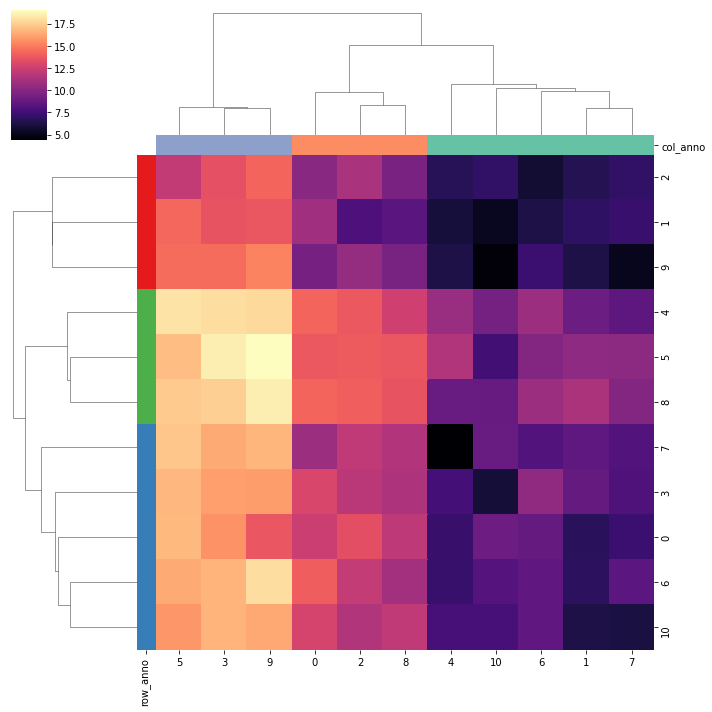

In [6]:
row_colors = row_clusters.map(
    dict(zip(range(1, 4), sns.color_palette("Set1", 3)))
).to_frame("row_anno")
col_colors = col_clusters.map(
    dict(zip(range(1, 4), sns.color_palette("Set2", 3)))
).to_frame("col_anno")
sns.clustermap(
    df,
    cmap="magma",
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_colors=row_colors,
    col_colors=col_colors,
)

# Annotated heatmap as crossplot

- annotated heatmaps are a common application of the crossplot function provided by codaplot
- the main dataframe is the only 'center' plot
- annotations are placed around the main heatmap as desirec

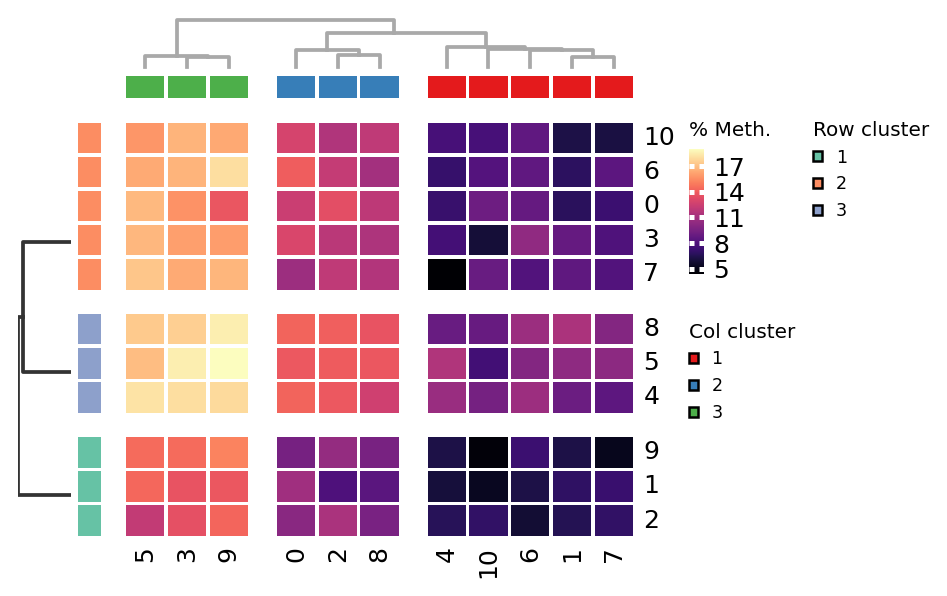

In [7]:
# fmt: off
array_to_figure_res, plot_arr = cross_plot(

    # Main heatmap
    # ------------
    # Color bar ticks and color bar style can be specified here
    # guide args also have a global default arg in cross_plot
    # the global default is overwritten completely if guide_args is specified here
    center_plots=[
        dict(
            df=df,
            cmap="magma",
            guide_title="% Meth.",
            edgecolor="white",
            guide_args=dict(shrink=0.3, aspect=3, ticks=[5, 8, 11, 14, 17]),
            cbar_styling_func_kwargs=dict(tick_length=2, tick_width=2),
        )
    ],
    center_margin_ticklabels=True,
    pads_around_center=[(0.2 / 2.54, "abs")],
    figsize=(15 / 2.54, 10 / 2.54),
    constrained_layout=False,
    layout_pads=dict(wspace=0.05, hspace=0.05),
    top_plots=[
        dict(
            df=pd.DataFrame({"col clusters": col_clusters}).T,
            cmap="Set1",
            guide_title="Col cluster",
            is_categorical=True,
            edgecolor="white",
        )
    ],
    top_row_sizes=[(0.5 / 2.54, "abs")],
    left_plots=[
        dict(
            df=pd.DataFrame({"row clusters": row_clusters}),
            cmap="Set2",
            guide_title="Row cluster",
            is_categorical=True,
            edgecolor="white",
        )
    ],
    left_col_sizes=[(0.5 / 2.54, "abs")],

    # Create Internal Clustering
    # -------------------
    # Trigger clustering within cross_plot
    # Atm, these need to be explicitely set to true to trigger clustering,
    # ie specifying truthy col_dendrogram is not sufficient
    # row_linkage=True,
    # col_linkage=True,

    # Use external Clustering
    # -----------------------
    row_linkage=row_linkage,
    col_linkage=col_linkage,

    # Spacing
    # -------
    row_spacing_group_ids=row_clusters,
    col_spacing_group_ids=col_clusters,
    row_spacer_sizes=0.05,
    col_spacer_sizes=0.05,

    # # Dendrograms
    # ==============
    #
    # Overview
    # --------
    #
    # - created with cut_dendrogram
    # - default args for cut_dendrogram
    #   cut_dendrogram_defaults = dict(
    #           stop_at_cluster_level=False, min_height=0, min_cluster_size=0
    #   )
    # - Can specify {row,col}_dendrogram as bool or dict with args for cut_dendrogram
    # - Note that cross_plot will fill several arguments automatically, including
    #   cluster_ids_data_order and spacing_groups
    #   - this means that spaced heatmaps automatically get spaced dendrograms
    #   - Therefore, to avoid colored links for spaced heatmaps, atm have to explicitely specify cluster_ids_data_order=None
    #
    # Relevant papercuts
    # ------------------
    # - the colors for colored dendrograms need to be manually specified to match (the optional) annotation heatmaps
    # - cluster level cut dendrograms are not aligned to the middle of the cluster
    # - in colored dendrograms, black parent links lie above the colored child links

    # This col dendrogram avoids colored links in the spaced heatmap
    col_dendrogram=dict(cluster_ids_data_order=None, base_color="darkgray"),
    # row_dendrogram=dict(cluster_ids_data_order=None, base_color="darkgray"),

    # This row dendrogram is cut at the cluster level
    row_dendrogram=dict(stop_at_cluster_level=True, base_color=(0.2, 0.2, 0.2)),

    # This row dendrogram is cut at a certain min cluster size (good for inspection purposes)
    # This will always ? use cluster colors, i think currently it is not possible to avoid coloring the links
    # according to a cmap, however, we can specify a dummy 'black' only cmap, with one entry per cluster id
    # row_dendrogram=dict(
    #     colors=["black"] * row_clusters.nunique(),
    #     stop_at_cluster_level=False,
    #     min_cluster_size=4,
    #     base_color=(0.2, 0.2, 0.2),
    # ),

    # A nice colored row dendrogram
    # The colors for colored dendrograms need to be manually specified to match (the optional) annotation heatmaps
    # row_dendrogram=dict(colors="Set2"),
    # kwargs here are completely overwritten if they are passed directly to a plotting
    # func
    default_plotting_func_kwargs=dict(guide_args=dict(shrink=0.3, aspect=8)),
)
# fmt: on

# A simple heatmap function

cross_plot uses co.plotting.heatmap, a simple heatmap function which can create spaced heatmaps, categorical heatmaps etc. with nice gimmicks like a nicely formatted colorbar; a colorbar can be added automatically, optionally on a specified guide_ax

{'shrink': 0.3,
 'aspect': 5,
 'ticks': [5, 8, 11, 14, 17],
 'mappable': <matplotlib.collections.QuadMesh at 0x2ad3aa00ac10>,
 'title': '% Meth.',
 'styling_func_kwargs': {'tick_length': 3, 'tick_width': 2}}

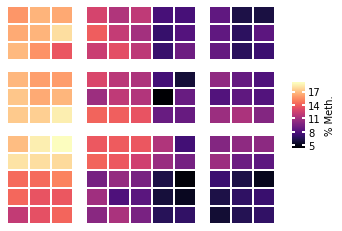

In [8]:
fig, ax = plt.subplots()
co.heatmap(
    df=df.iloc[leaves_list(row_linkage), leaves_list(col_linkage)],
    ax=ax,
    cmap="magma",
    show_guide=True,
    guide_title="% Meth.",
    edgecolor="white",
    col_spacing_group_ids=col_clusters,
    row_spacing_group_ids=row_clusters,
    col_spacer_sizes=0.05,
    row_spacer_sizes=0.05,
    guide_args=dict(shrink=0.3, aspect=5, ticks=[5, 8, 11, 14, 17]),
    cbar_styling_func_kwargs=dict(tick_length=3, tick_width=2),
)

# Framed group annotations

Currently, this requires using a dict for co.frame_groups(colors), mapping cluster ids to colors
Note that the non-consecutive cluster id order is not a bug, this was specified likes this manually above

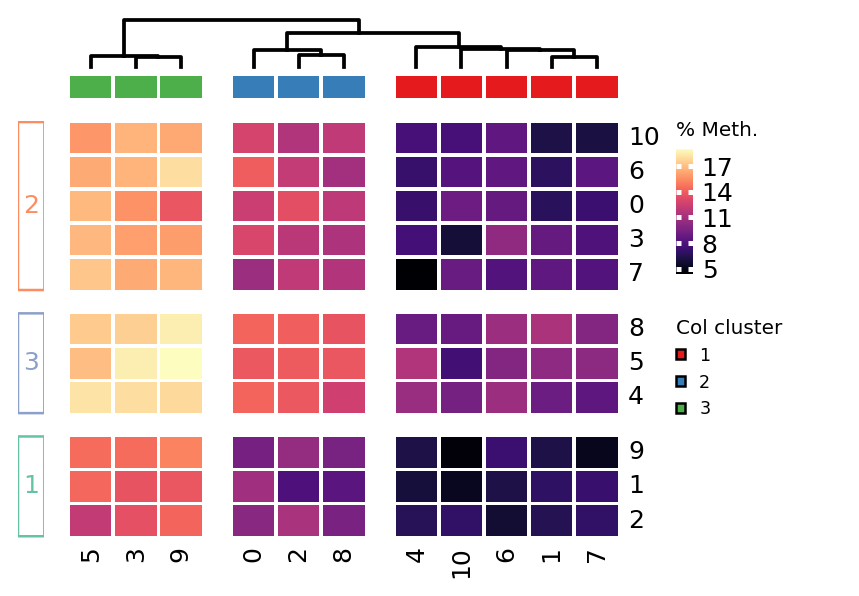

In [9]:
array_to_figure_res, plot_arr = cross_plot(
    center_plots=[
        dict(
            df=df,
            cmap="magma",
            guide_title="% Meth.",
            edgecolor="white",
            guide_args=dict(shrink=0.3, aspect=3, ticks=[5, 8, 11, 14, 17]),
            cbar_styling_func_kwargs=dict(tick_length=2, tick_width=2),
        )
    ],
    center_margin_ticklabels=True,
    pads_around_center=[(0.2 / 2.54, "abs")],
    figsize=(15 / 2.54, 10 / 2.54),
    constrained_layout=False,
    layout_pads=dict(wspace=0.05, hspace=0.05),
    top_plots=[
        dict(
            df=pd.DataFrame({"col clusters": col_clusters}).T,
            cmap="Set1",
            guide_title="Col cluster",
            is_categorical=True,
            edgecolor="white",
        )
    ],
    top_row_sizes=[(0.5 / 2.54, "abs")],
    left_plots=[
        dict(
            _func=co.frame_groups,
            direction="y",
            colors=dict(
                zip(
                    np.unique(row_clusters),
                    sns.color_palette("Set2", n_colors=row_clusters.nunique()),
                )
            ),
            linewidth=1,
            add_labels=True,
            labels=None,
            label_colors=None,
            label_groups_kwargs=dict(rotation=0),
        )
    ],
    left_col_sizes=[(0.5 / 2.54, "abs")],
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_spacing_group_ids=row_clusters,
    col_spacing_group_ids=col_clusters,
    row_spacer_sizes=0.05,
    col_spacer_sizes=0.05,
    col_dendrogram=dict(cluster_ids_data_order=None),
    # row_dendrogram=dict(cluster_ids_data_order=None),
)

# Minimal annotated heatmap with cross_plot

## Non-spaced

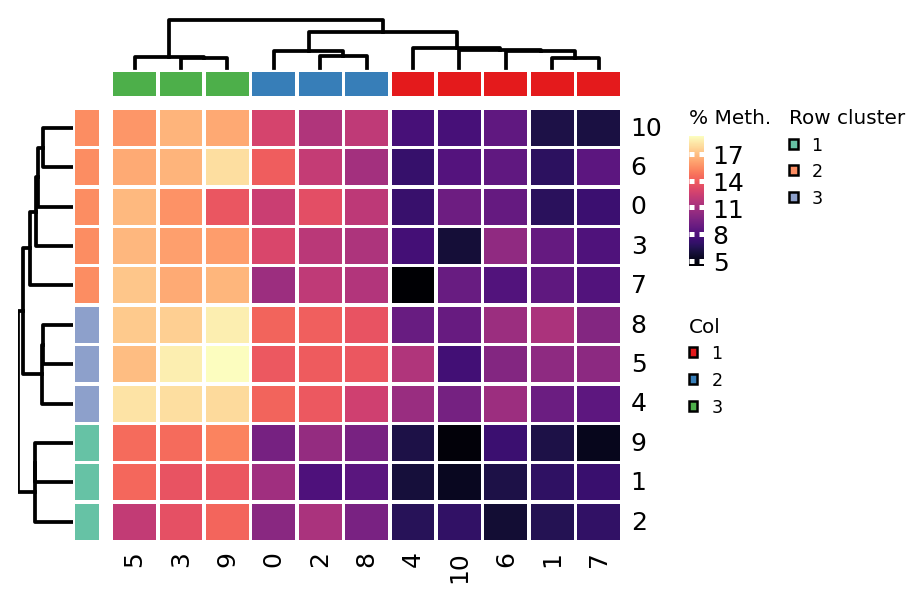

In [10]:
better_cross_plot_default_args = dict(
        pads_around_center=[(0.2 / 2.54, "abs")],
        constrained_layout=False,
        # this should work with both gridspec and constrained layout
        layout_pads=dict(hspace=0, wspace=0, h_pad=0, w_pad=0),
)
array_to_figure_res, plot_arr = cross_plot(
        center_plots=[
            dict(
                    df=df,
                    cmap="magma",
                    guide_title="% Meth.",
                    edgecolor="white",
                    guide_args=dict(shrink=0.3, aspect=3, ticks=[5, 8, 11, 14, 17]),
                    cbar_styling_func_kwargs=dict(tick_length=2, tick_width=2),
                    xticklabels=True,
                    yticklabels=True,
            )
        ],
        # Leaving center_margin_ticklabels at the default=False allows control in plotting args above
        # center_margin_ticklabels=True,
        top_plots=[
            dict(
                    df=pd.DataFrame({"col clusters": col_clusters}).T,
                    cmap="Set1",
                    guide_title="Col",
                    is_categorical=True,
                    edgecolor="white",
            )
        ],
        top_row_sizes=[(0.5 / 2.54, "abs")],
        left_plots=[
            dict(
                    df=pd.DataFrame({"row clusters": row_clusters}),
                    cmap="Set2",
                    guide_title="Row cluster",
                    is_categorical=True,
                    edgecolor="white",
            )
        ],
        left_col_sizes=[(0.5 / 2.54, "abs")],
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        col_dendrogram=True,
        row_dendrogram=True,
        # atm cross_plot does not seem to take yticklabels into account, so needs to be adapted to different label sizes
        legend_pad=(0.4, 'abs'),
        figsize=(15 / 2.54, 10 / 2.54),
        **better_cross_plot_default_args,
)

## Spaced

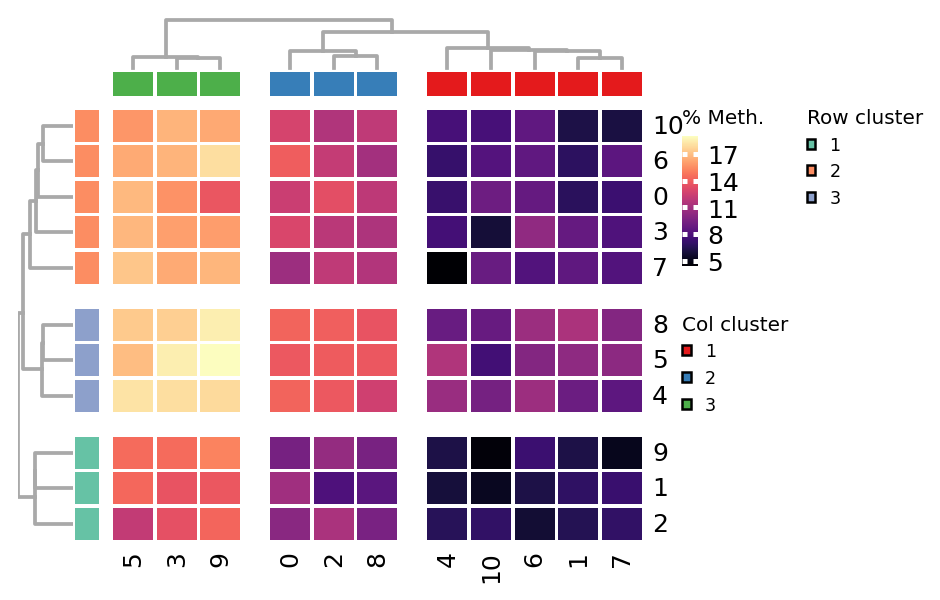

In [11]:
better_cross_plot_default_args = dict(
    pads_around_center=[(0.2 / 2.54, "abs")],
    constrained_layout=False,
    layout_pads=dict(hspace=0, wspace=0),
    center_margin_ticklabels=True,
)
array_to_figure_res, plot_arr = cross_plot(
        center_plots=[
            dict(
                    df=df,
                    cmap="magma",
                    guide_title="% Meth.",
                    edgecolor="white",
                    guide_args=dict(shrink=0.3, aspect=3, ticks=[5, 8, 11, 14, 17]),
                    cbar_styling_func_kwargs=dict(tick_length=2, tick_width=2),
            )
        ],
        top_plots=[
            dict(
                    df=pd.DataFrame({"col clusters": col_clusters}).T,
                    cmap="Set1",
                    guide_title="Col cluster",
                    is_categorical=True,
                    edgecolor="white",
            )
        ],
        top_row_sizes=[(0.5 / 2.54, "abs")],
        left_plots=[
            dict(
                    df=pd.DataFrame({"row clusters": row_clusters}),
                    cmap="Set2",
                    guide_title="Row cluster",
                    is_categorical=True,
                    edgecolor="white",
            )
        ],
        left_col_sizes=[(0.5 / 2.54, "abs")],
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        row_spacing_group_ids=row_clusters,
        col_spacing_group_ids=col_clusters,
        row_spacer_sizes=0.05,
        col_spacer_sizes=0.05,
        col_dendrogram=dict(cluster_ids_data_order=None, base_color="darkgray"),
        row_dendrogram=dict(cluster_ids_data_order=None, base_color="darkgray"),
        # row_dendrogram=True,
        figsize=(15 / 2.54, 10 / 2.54),
        **better_cross_plot_default_args
)

# Cross plots allow more than one main dataset to be displayed in the center of the plot

Interesting aspects of this example
- alignment of plot elements is done by hand

In [12]:
@anno_axes("right")
def spaced_barplot(ax, **kwargs):
    ax.barh(**kwargs)

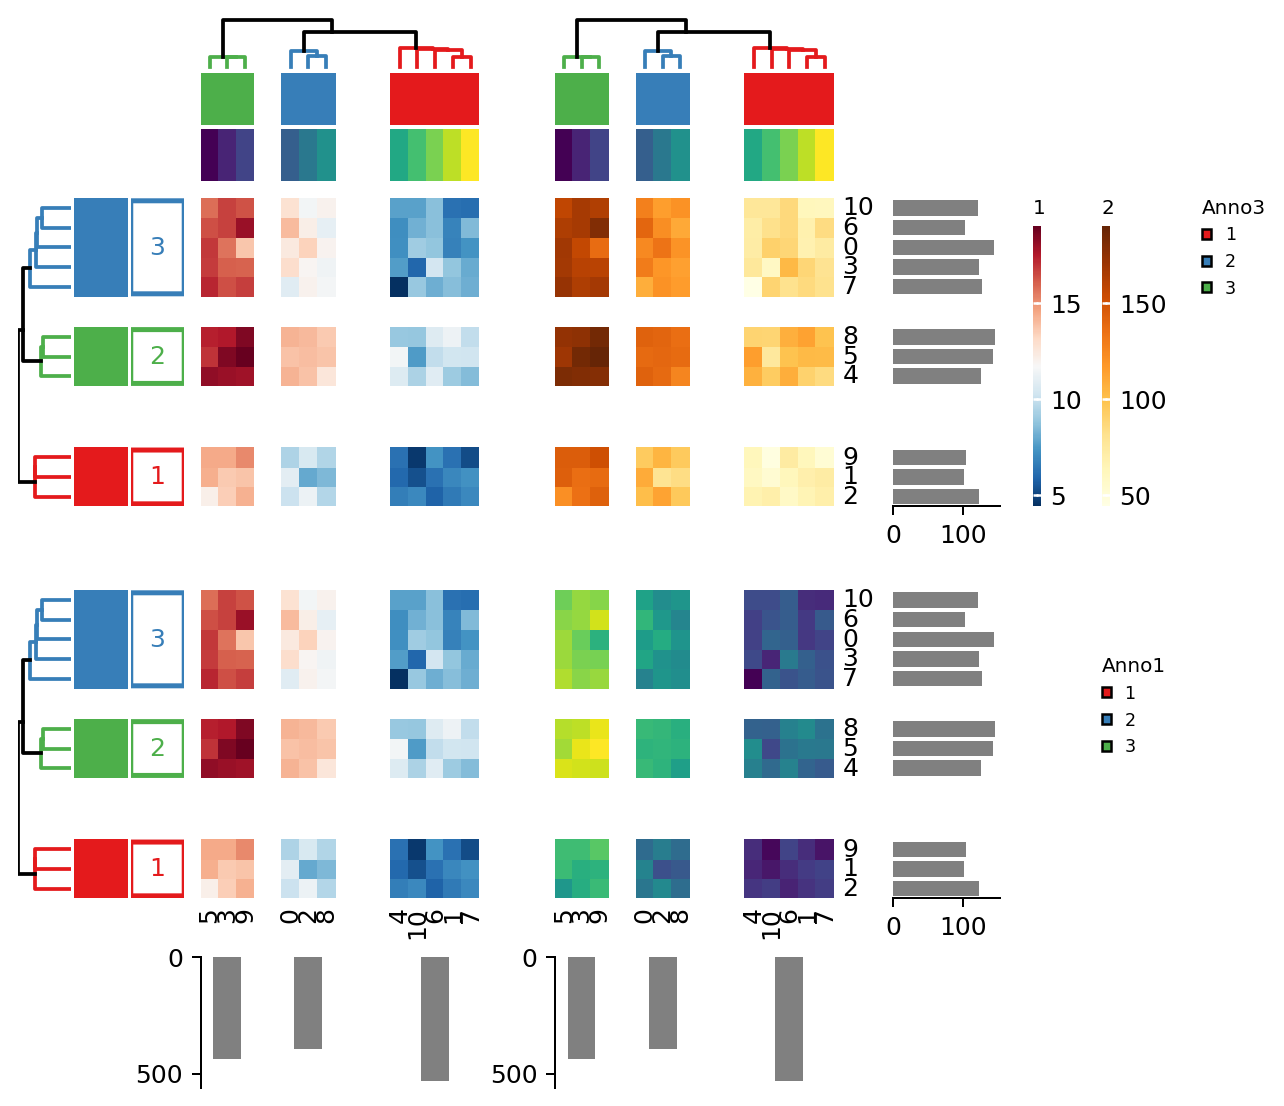

In [13]:
figsize = (20 / 2.54, 20 / 2.54)
figsize_ratio = figsize[0] / figsize[1]
res, plot_array = cross_plot(
    figsize=figsize,
    constrained_layout=False,
    layout_pads=dict(h_pad=0, w_pad=0, hspace=0.03, wspace=0.03),
    center_margin_ticklabels=True,
    center_col_pad=(0.25 / figsize_ratio, "rel"),
    center_row_pad=(0.25, "rel"),
    align_args=False,
    pads_around_center=[
        (0.2 / 2.54, "abs"),
        (1 / 2.54, "abs"),
        (1 / 2.54, "abs"),
        (0.2 / 2.54, "abs"),
    ],
    legend_args=dict(xpad_in=0.2, guide_titles=None),
    legend_extent=["center"],
    legend_axes_selectors=["ae1", "ae2", "ae3", (4, 1)],
    center_plots=np.array(
        [
            [
                dict(
                    _name="ae1",
                    guide_title="1",
                    df=df.iloc[row_order, col_order],
                    cmap="RdBu_r",
                ),
                dict(
                    _name="ae2",
                    guide_title="2",
                    df=df.iloc[row_order, col_order] * 10,
                    cmap="YlOrBr",
                ),
            ],
            [
                dict(
                    guide_title="3",
                    df=df.iloc[row_order, col_order] * 5,
                    cmap="RdBu_r",
                ),
                dict(
                    guide_title="3",
                    df=df.iloc[row_order, col_order] * 2,
                    cmap="viridis",
                ),
            ],
        ]
    ),
    top_plots=[
        dict(
            _name="ae3",
            guide_title="Anno1",
            df=pd.DataFrame({"anno1": col_clusters}).T.iloc[:, col_order],
            is_categorical=True,
            cmap="Set1",
            guide_args=dict(),
        ),
        dict(df=pd.DataFrame({"values": np.arange(11)}).T, guide_title="anno2"),
    ],
    top_row_sizes=[(1 / 2.54, "abs"), (1 / 2.54, "abs")],
    left_plots=[
        dict(
            df=pd.DataFrame({"anno2": pd.Series(row_clusters)[row_order].astype(str)}),
            guide_title="Anno3",
        ),
        dict(
            _func=anno_axes(loc="left", prune_all=True)(co.plotting.frame_groups),
            # group_ids=row_clusters[row_order],
            direction="y",
            colors=dict(zip([1, 2, 3], sns.color_palette("Set1", 3))),
            linewidth=2,
            add_labels=True,
            labels=["1", "2", "3"],
            label_colors=None,
            label_groups_kwargs=dict(rotation=0),
        ),
    ],
    left_col_sizes=[(1 / 2.54, "abs"), (1 / 2.54, "abs")],
    right_plots=[
        dict(
            _func=spaced_barplot,
            y=np.arange(0, df.shape[0]) + 0.5,
            width=df.sum(axis=1),
            # TODO: height not calculated automatically
            height=0.05,
            color="gray",
        )
    ],
    right_row_sizes=[(2 / 2.54, "abs")],
    # left=None,
    # left_sizes=None,
    bottom_plots=[
        dict(
            _func=anno_axes("bottom")(plt.bar),
            x=co.plotting.find_stretches2(col_clusters[col_order])[1],
            height=df.groupby(col_clusters, axis=1).sum().sum(axis=0),
            width=0.1,
            color="gray",
        )
    ],
    bottom_row_sizes=[(2.5 / 2.54, "abs")],
    row_dendrogram=True,
    col_dendrogram=True,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    row_spacing_group_ids=pd.Series(row_clusters)[row_order],
    col_spacing_group_ids=pd.Series(col_clusters)[col_order],
    row_spacer_sizes=[0.2, 0.1],
    col_spacer_sizes=[0.1, 0.2],
    default_plotting_func=co.plotting.heatmap,
    default_plotting_func_kwargs=dict(
        guide_args=dict(shrink=0.4, aspect=4), xticklabel_rotation=90
    ),
)

# Automatic alignment and distribution of data within the cross plot

In [14]:
@anno_axes(loc="right")
def spaced_barplot2(df, spacing_group_ids, spacer_sizes, ax):
    ax.barh(
        y=adjust_coords(
            np.arange(0, df.shape[0]) + 0.5,
            spacing_group_ids=spacing_group_ids,
            spacer_sizes=spacer_sizes,
        ),
        width=df.sum(axis=1),
        # TODO: height not calculated automatically
        height=0.05,
        color="gray",
    )

In [15]:
@anno_axes(loc="right")
def spaced_barplot3(df, y, ax):
    ax.barh(
        y=y,
        width=df.sum(axis=1),
        # TODO: height not calculated automatically
        height=0.05,
        color="gray",
    )

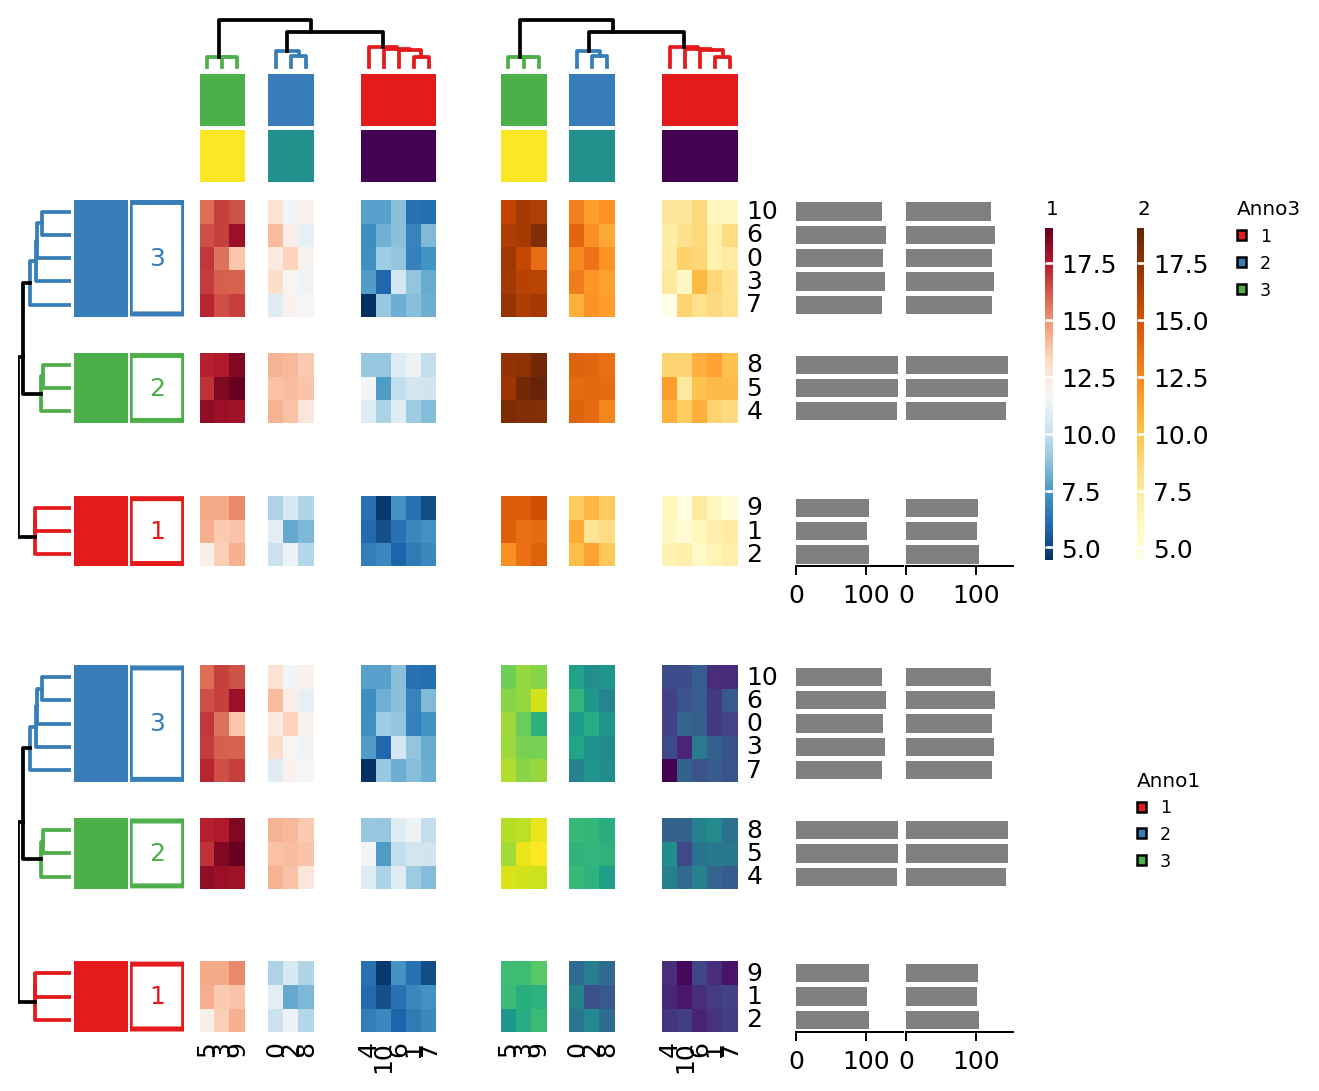

In [16]:
figsize = (20 / 2.54, 20 / 2.54)
figsize_ratio = figsize[0] / figsize[1]
res, plot_array = cross_plot(
    figsize=figsize,
    constrained_layout=False,
    layout_pads=dict(h_pad=0, w_pad=0, hspace=0.03, wspace=0.03),
    center_margin_ticklabels=True,
    center_col_pad=(0.25 / figsize_ratio, "rel"),
    center_row_pad=(0.25, "rel"),
    pads_around_center=[
        (0.2 / 2.54, "abs"),
        (1 / 2.54, "abs"),
        (1 / 2.54, "abs"),
        (0.2 / 2.54, "abs"),
    ],
    legend_args=dict(xpad_in=0.2, guide_titles=None),
    legend_extent=["center"],
    legend_axes_selectors=["ae1", "ae2", "ae3", (4, 1)],
    row_dendrogram=True,
    col_dendrogram=True,
    row_linkage=True,
    col_linkage=True,
    row_spacing_group_ids=pd.Series(row_clusters),
    col_spacing_group_ids=pd.Series(col_clusters),
    row_spacer_sizes=[0.2, 0.1],
    col_spacer_sizes=[0.1, 0.2],
    default_plotting_func=co.plotting.heatmap,
    default_plotting_func_kwargs=dict(
        guide_args=dict(shrink=0.4, aspect=4), xticklabel_rotation=90
    ),
    center_plots=np.array(
        [
            [
                dict(_name="ae1", guide_title="1", df=df, cmap="RdBu_r"),
                dict(_name="ae2", guide_title="2", df=df, cmap="YlOrBr"),
            ],
            [
                dict(guide_title="3", df=df, cmap="RdBu_r"),
                dict(guide_title="3", df=df, cmap="viridis"),
            ],
        ]
    ),
    top_plots=[
        dict(
            _name="ae3",
            guide_title="Anno1",
            df=pd.DataFrame({"anno1": col_clusters}).T,
            is_categorical=True,
            cmap="Set1",
            guide_args=dict(),
        ),
        dict(df=pd.DataFrame({"values": col_clusters}).T, guide_title="anno2"),
    ],
    top_row_sizes=[(1 / 2.54, "abs"), (1 / 2.54, "abs")],
    left_plots=[
        dict(
            df=pd.DataFrame({"anno2": pd.Series(row_clusters).astype(str)}),
            guide_title="Anno3",
        ),
        dict(
            _func=anno_axes(loc="left", prune_all=True)(co.plotting.frame_groups),
            # group_ids=row_clusters[row_order],
            direction="y",
            colors=dict(zip([1, 2, 3], sns.color_palette("Set1", 3))),
            linewidth=2,
            add_labels=True,
            labels=["1", "2", "3"],
            label_colors=None,
            label_groups_kwargs=dict(rotation=0),
        ),
    ],
    left_col_sizes=[(1 / 2.54, "abs"), (1 / 2.54, "abs")],
    right_plots=[
        dict(_func=spaced_barplot2, df=df),
        dict(_func=spaced_barplot3, y=np.arange(df.shape[1]) + 0.5, df=df),
    ],
    right_row_sizes=[(2 / 2.54, "abs"), (2 / 2.54, "abs")],
)